In [1]:
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import PIL.ImageOps
import pandas as pd
from PIL import ImageFilter
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import joblib

%matplotlib inline

format_small_size = (60,32) # minimal possible size of logo
format_small_area = format_small_size[0]*format_small_size[1]

### extracting data from orig.jpg

In [2]:
# transformation functions

def rotator(img,angle): 
    rot = img.convert('RGBA').rotate(angle, expand=1)
    bg = Image.new('RGBA', rot.size, (255,)*4)
    res = Image.composite(rot, bg, rot)
    return res.convert(img.mode)

def crop_single(img,line_num,col_num,size):
    x1 = col_num*size[0]/2
    x2 = x1+size[0]
    y1 = line_num*size[1]/2
    y2 = y1+size[1]
    crop = img.convert('RGBA').crop((x1,y1,x2,y2))
    bg = Image.new('RGBA', crop.size, (255,)*4)
    res = Image.composite(crop, bg, crop)
    return res.convert(img.mode)

def crop_img(img):
    croped_imgs = []
    for i in range(0,img.size[0]*2//60):
        for j in range(0,img.size[1]*2//32):
            crop = crop_single(img,j,i,(60,32))
            croped_imgs.append(crop)
    return croped_imgs

def empty_filter(imgs): # filters out examples with too big amount of the same colored pixels (which are empty)
    res=[]
    for img in imgs:
        count = Counter(np.array(img).reshape(1,1920)[0])
        max_count = max([count[c] for c in count])
        if max_count<1650: # threshold (can be changed)
            res.append(img)
    return res

def shifted(img,size):
    bg=Image.new('RGBA',[s*4//3 for s in size],(255,255,255,255))
    bg.paste(img,[s//6 for s in size])
    return bg.convert(img.mode)

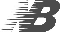

In [3]:
orig=Image.open('../orig.jpg').convert(mode='L').resize(format_small_size)
orig

In [4]:
# transformations
origs = [rotator(orig,15*i) for i in range(-6,8)]
origs = origs+[shifted(orig,format_small_size) for orig in origs]
origs = [img.filter(ImageFilter.CONTOUR) for img in origs]
origs=sum([crop_img(img) for img in origs], [])
origs=empty_filter(origs)
len(origs) # seems to be very small

80

In [5]:
orig_data = []
for orig in origs: # turns imgs from origs into data lines and scales them
    line=np.array(orig).reshape(1,format_small_area)[0]
    line_min=min(line)
    delta=max(line)-line_min # delta can't be zero, because such examples already filtred out
    orig_data.append([(x-line_min)/delta for x in line])
    
orig_data = pd.DataFrame(orig_data)
orig_data['y'] = 1 # because this examples contain logo
orig_data.to_csv('../data/orig_data.csv')

In [6]:
for i in range(0,2):
    orig_data = orig_data.append(orig_data)
    
l=len(orig_data)
l

320

### extracting data from examples

In [7]:
small = !ls ../examples/1/
medium = !ls ../examples/2/
big = !ls ../examples/3/
len(small),len(medium),len(big)

(20735, 6094, 2820)

assume first n small images do not contain logo (even if some of them obviously do)

In [8]:
def contour(name,i): # turns imges in contoured data (i is number of folder)
    img = Image.open('../examples/'+str(i)+'/'+name).resize(format_small_size).filter(ImageFilter.CONTOUR)
    line=np.array(img).reshape(1,format_small_area)[0]
    min_line = min(line)
    delta = max(line)-min_line
    if delta>0:
        return [(t-min_line)/delta for t in line] # rescaled line
    else:
        return np.zeros(len(line)) # simple zeros line

In [9]:
small_data_cont = [contour(t,1) for t in small[0:l*6]] # let small data be 3 times bigger than orig_data

In [10]:
small_data = pd.DataFrame(np.array(small_data_cont))
small_data['y'] = 0
small_data.to_csv('../data/small_data_zeros.csv')

In [11]:
small_data.head()

0        1         2         3         4         5         6  \
0  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.00000  0.007843  0.047059  0.345098  0.294118  0.372549   
4  0.329412  0.34902  0.333333  0.329412  0.356863  0.352941  0.337255   

          7         8         9 ...      1911      1912      1913      1914  \
0  0.000000  0.000000  0.000000 ...  0.341176  0.341176  0.341176  0.341176   
1  0.000000  0.000000  0.000000 ...  0.345098  0.337255  0.337255  0.333333   
2  0.000000  0.000000  0.000000 ...  0.000000  0.000000  0.000000  0.000000   
3  0.329412  0.364706  0.341176 ...  0.039216  0.011765  0.007843  0.003922   
4  0.356863  0.337255  0.321569 ...  0.341176  0.282353  0.337255  0.325490   

       1915      1916      1917      1918      1919  y  
0  0.341176  0.341176  0.341176  0.341176  0.341176  0  
1  0.321569  0.000000  0.345098  0.321569  0.364706  0  
2  0.000000  0.000000  0.000000  0.000000  0.000000  0  
3  0.000000  0.000000  0.000000  0.000000  0.000000  0  
4  0.290196  0.321569  0.337255  0.360784  0.364706  0  

[5 rows x 1921 columns]

Now let's find few positive examples in first l*3 examples

In [ ]:
#for file in small[0:l]:
for file in small[0:10]: # I was lucky to find six positive examples in first ten
    imshow(np.array(Image.open('../examples/1/'+file)), cmap="gray")
    plt.show()
    print(file)

In [12]:
positive_examples = [
    'nbsklep.pl_21_x_9_y_16_label0.jpg',
    'nbsklep.pl_21_x_9_y_17_label0.jpg',
    'nbsklep.pl_0_x_4_y_23_label0.jpg',
    'lt.wikipedia.org_0_x_0_y_0_label0.jpg',
    'lt.wikipedia.org_0_x_0_y_1_label0.jpg',
    'lt.wikipedia.org_0_x_1_y_0_label0.jpg',
    'lt.wikipedia.org_0_x_1_y_1_label0.jpg',
    'lt.wikipedia.org_0_x_2_y_0_label0.jpg',
    'nbsklep.pl_2_x_32_y_12_label0.jpg',
    'nbsklep.pl_2_x_33_y_12_label0.jpg',
    'nbsklep.pl_2_x_34_y_12_label0.jpg',
    'nbsklep.pl_2_x_35_y_10_label0.jpg',
    'nbsklep.pl_2_x_35_y_11_label0.jpg',
    'nbsklep.pl_2_x_35_y_12_label0.jpg',
    'nbsklep.pl_13_x_7_y_5_label0.jpg',
    'nbsklep.pl_13_x_7_y_6_label0.jpg',
    'nbsklep.pl_13_x_8_y_5_label0.jpg',
    'nbsklep.pl_13_x_8_y_6_label0.jpg',
    'nbsklep.pl_25_x_7_y_5_label0.jpg',
    'nbsklep.pl_25_x_7_y_6_label0.jpg',
    'nbsklep.pl_26_x_6_y_8_label0.jpg',
    'nbsklep.pl_26_x_7_y_8_label0.jpg',
    'nbsklep.pl_26_x_7_y_9_label0.jpg',
    'nbsklep.pl_26_x_7_y_10_label0.jpg',
    'nbsklep.pl_26_x_8_y_7_label0.jpg',
    'nbsklep.pl_26_x_8_y_8_label0.jpg',
    'nbsklep.pl_26_x_8_y_9_label0.jpg',
    'nbsklep.pl_6_x_6_y_8_label0.jpg',
    'nbsklep.pl_6_x_7_y_8_label0.jpg',
    'nbsklep.pl_6_x_7_y_9_label0.jpg',
    'nbsklep.pl_6_x_8_y_7_label0.jpg',
    'nbsklep.pl_6_x_8_y_9_label0.jpg',
    'nbsklep.pl_4_x_24_y_34_label0.jpg',
    'nbsklep.pl_4_x_23_y_33_label0.jpg',
    'nbsklep.pl_4_x_23_y_34_label0.jpg',
    'nbsklep.pl_4_x_10_y_16_label0.jpg'] # I've found only first six

indexes_of_true_examples = [small.index(file) for file in positive_examples] # indexes of corresponding lines in dataframe
indexes_in_small = [index for index in indexes_of_true_examples if index in small_data.index]
small_data.at[indexes_in_small, 'y'] = 1.0 # label this examples as positive in dataframe

as there still are only few examples let's use them more than once

In [13]:
print(len(small_data))
for i in range(0,40):
    small_data = small_data.append(small_data.iloc[indexes_in_small])
    
print(len(small_data))

1920
2160


In [14]:
data = np.vstack((small_data,orig_data))

### training classifier

In [34]:
classifiers = []
def train_and_predict(data,itter):
    
    x_train, x_test, y_train, y_test = train_test_split( data[:,0:-1], data[:,-1], test_size=0.2)

    neuro = MLPClassifier(alpha=0.03,hidden_layer_sizes=[10,10,5,5], max_iter=400)
    neuro.fit(x_train,y_train)
    neuro_predict_test = neuro.predict(x_test)
    neuro_predict_train = neuro.predict(x_train)
    metric_train = metrics.roc_auc_score(y_train, neuro_predict_train)
    metric_test = metrics.roc_auc_score(y_test, neuro_predict_test)
    print('train auc: {}'.format(metric_train))
    print('test auc: {}'.format(metric_test))
    classifiers.append(neuro)
    filename = '../models/mlpc_{}_{}_{}.sav'.format(metric_train,metric_test,itter)
    joblib.dump(neuro, filename)
    
    positive_predicted = []
    
    # let's see if our classifier will find positive results
    for file in small:
        img_np = np.array(contour(file,1))
        predict = neuro.predict(img_np.reshape(1,-1))[0]
        if predict == 1:
            imshow(np.array(Image.open('../examples/1/'+file)), cmap='gray') # let's see what images predicted to contain logo
            plt.show()
            print(file)
            positive_predicted.append(file)

    print('positive predicted: {}'.format(len(positive_predicted)))
    return positive_predicted

def add_data(data,positive_examples):
    negative_examples = [file for file in positive_predicted if not file in positive_examples]
    data_to_add = np.vstack(([contour(name,1)+[1.0] for name in positive_examples],[contour(name,1)+[0.0] for name in negative_examples]))
    data_to_add = pd.DataFrame(data_to_add).rename(index=str, columns={1920: "y"})
    for i in range(0,10):
        data = np.vstack((data,data_to_add))
    print('added {} positive, {} negative, total: {}'.format(len(positive_examples),len(negative_examples), len(data_to_add)))
    return data

train auc: 1.0
test auc: 0.9994714587737843


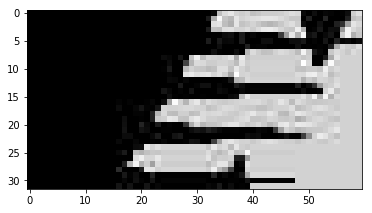

lt.wikipedia.org_0_x_0_y_0_label0.jpg


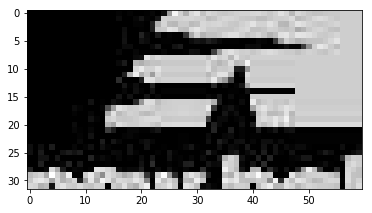

lt.wikipedia.org_0_x_0_y_1_label0.jpg


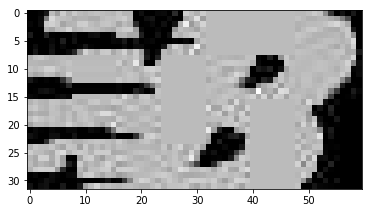

lt.wikipedia.org_0_x_1_y_0_label0.jpg


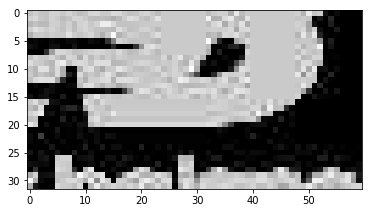

lt.wikipedia.org_0_x_1_y_1_label0.jpg


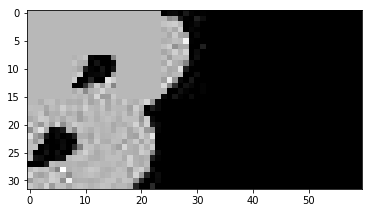

lt.wikipedia.org_0_x_2_y_0_label0.jpg


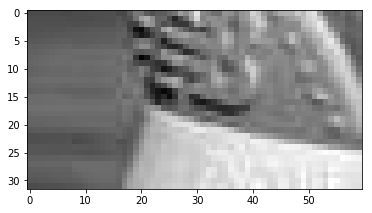

nbsklep.pl_0_x_4_y_23_label0.jpg


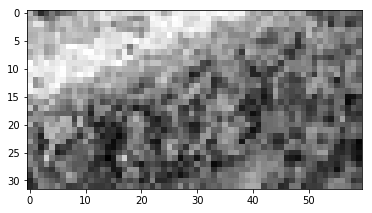

nbsklep.pl_12_x_1_y_27_label0.jpg


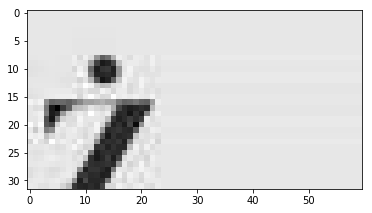

nbsklep.pl_13_x_12_y_11_label0.jpg


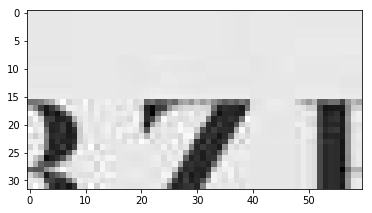

nbsklep.pl_13_x_7_y_11_label0.jpg


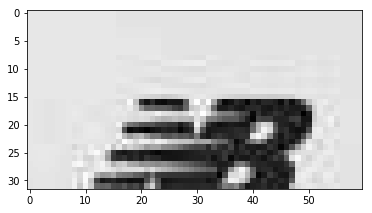

nbsklep.pl_13_x_7_y_5_label0.jpg


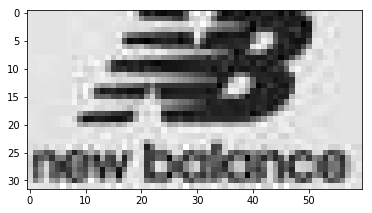

nbsklep.pl_13_x_7_y_6_label0.jpg


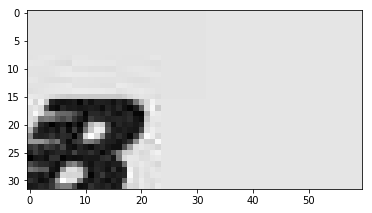

nbsklep.pl_13_x_8_y_5_label0.jpg


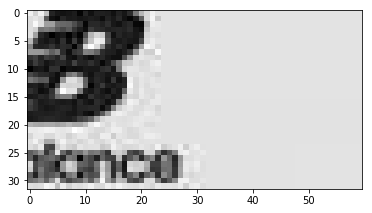

nbsklep.pl_13_x_8_y_6_label0.jpg


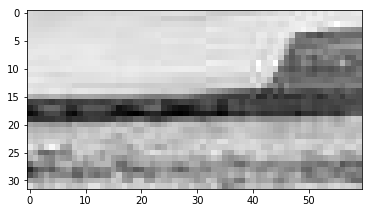

nbsklep.pl_14_x_7_y_20_label0.jpg


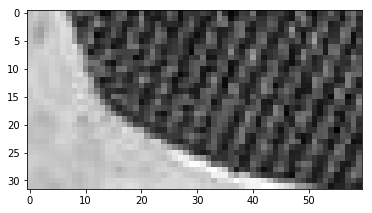

nbsklep.pl_15_x_1_y_12_label0.jpg


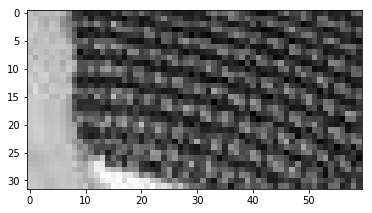

nbsklep.pl_15_x_1_y_21_label0.jpg


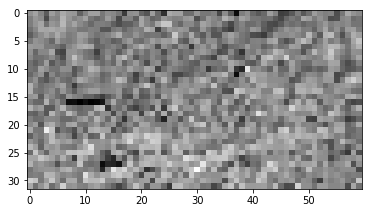

nbsklep.pl_17_x_13_y_26_label0.jpg


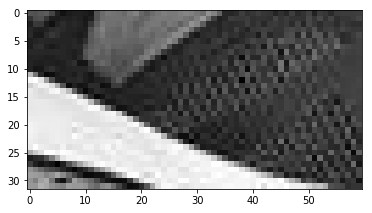

nbsklep.pl_17_x_8_y_27_label0.jpg


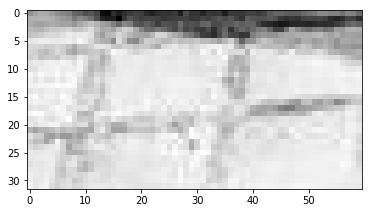

nbsklep.pl_21_x_13_y_22_label0.jpg


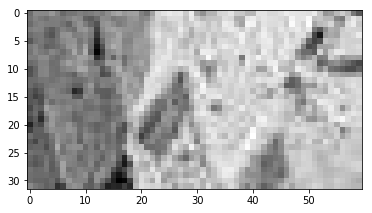

nbsklep.pl_21_x_6_y_21_label0.jpg


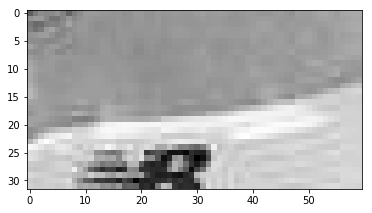

nbsklep.pl_21_x_9_y_16_label0.jpg


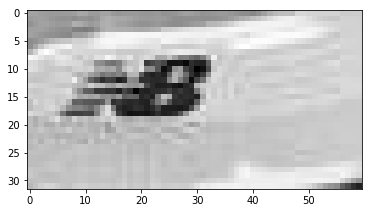

nbsklep.pl_21_x_9_y_17_label0.jpg


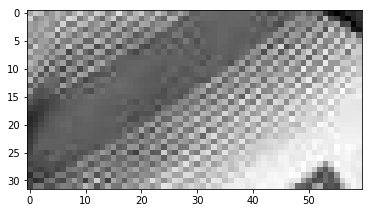

nbsklep.pl_22_x_4_y_2_label0.jpg


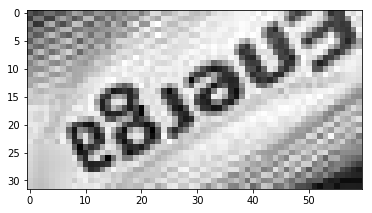

nbsklep.pl_22_x_4_y_4_label0.jpg


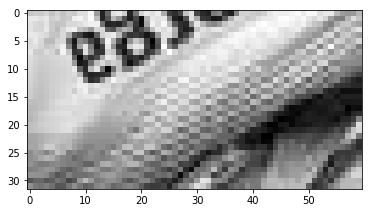

nbsklep.pl_22_x_4_y_5_label0.jpg


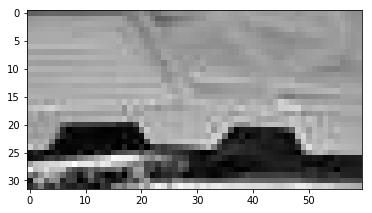

nbsklep.pl_24_x_4_y_20_label0.jpg


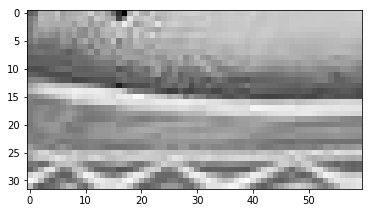

nbsklep.pl_24_x_7_y_19_label0.jpg


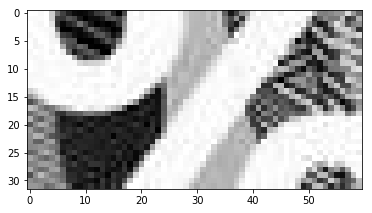

nbsklep.pl_25_x_10_y_13_label0.jpg


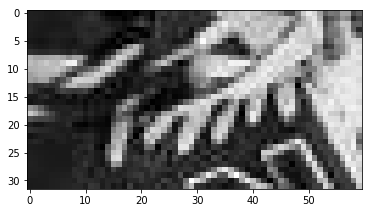

nbsklep.pl_25_x_10_y_24_label0.jpg


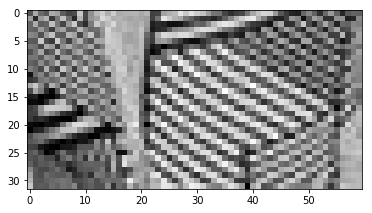

nbsklep.pl_25_x_11_y_10_label0.jpg


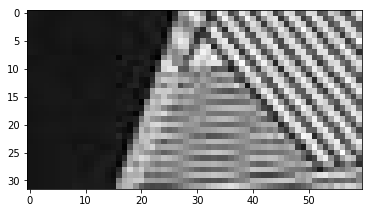

nbsklep.pl_25_x_11_y_1_label0.jpg


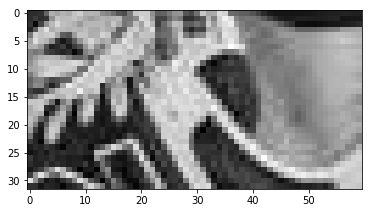

nbsklep.pl_25_x_11_y_24_label0.jpg


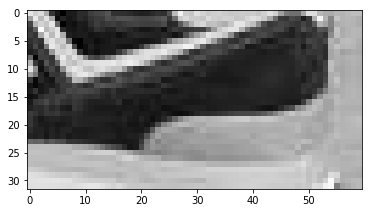

nbsklep.pl_25_x_12_y_26_label0.jpg


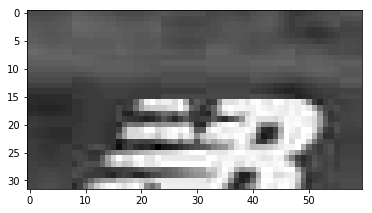

nbsklep.pl_25_x_7_y_5_label0.jpg


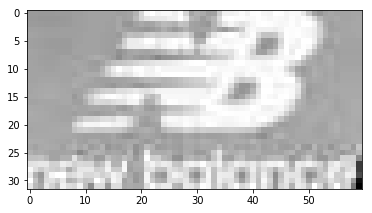

nbsklep.pl_25_x_7_y_6_label0.jpg


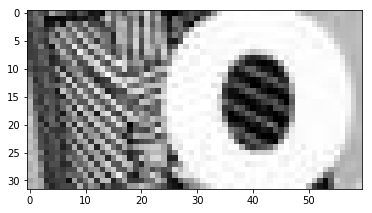

nbsklep.pl_25_x_9_y_12_label0.jpg


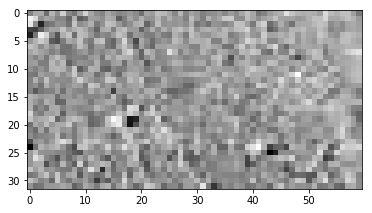

nbsklep.pl_26_x_5_y_28_label0.jpg


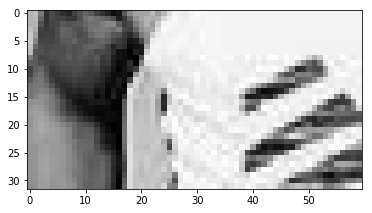

nbsklep.pl_26_x_6_y_8_label0.jpg


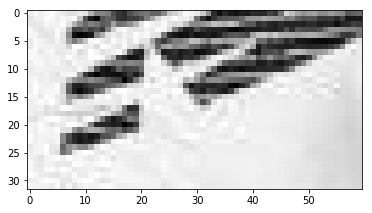

nbsklep.pl_26_x_7_y_10_label0.jpg


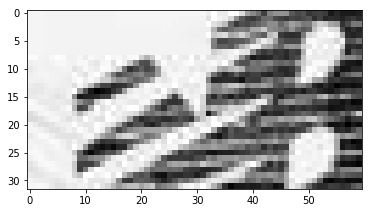

nbsklep.pl_26_x_7_y_8_label0.jpg


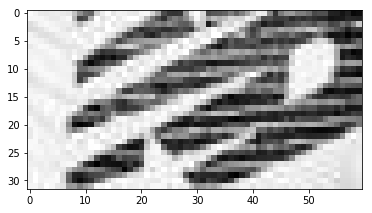

nbsklep.pl_26_x_7_y_9_label0.jpg


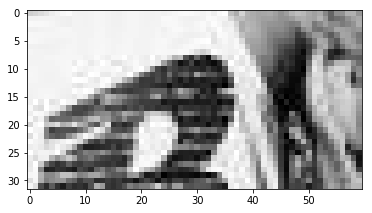

nbsklep.pl_26_x_8_y_7_label0.jpg


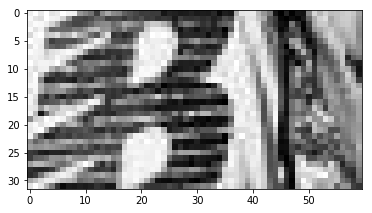

nbsklep.pl_26_x_8_y_8_label0.jpg


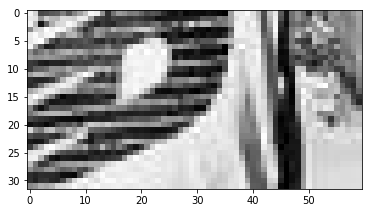

nbsklep.pl_26_x_8_y_9_label0.jpg


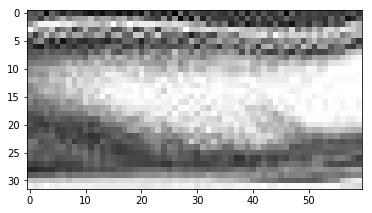

nbsklep.pl_27_x_11_y_20_label0.jpg


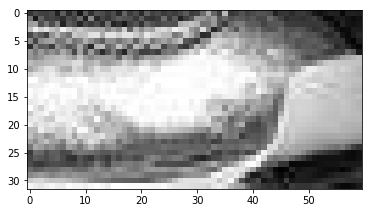

nbsklep.pl_27_x_12_y_20_label0.jpg


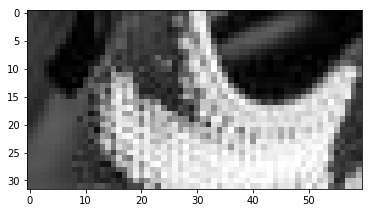

nbsklep.pl_29_x_5_y_18_label0.jpg


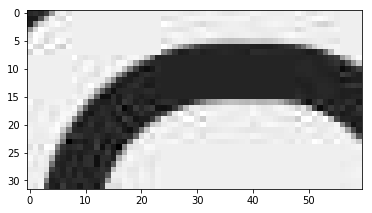

nbsklep.pl_2_x_12_y_16_label0.jpg


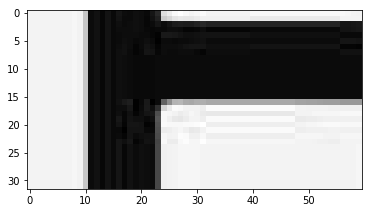

nbsklep.pl_2_x_1_y_18_label0.jpg


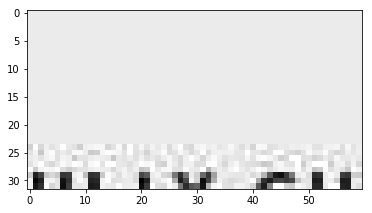

nbsklep.pl_2_x_23_y_33_label0.jpg


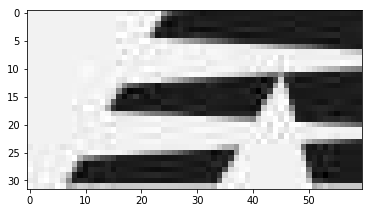

nbsklep.pl_2_x_32_y_12_label0.jpg


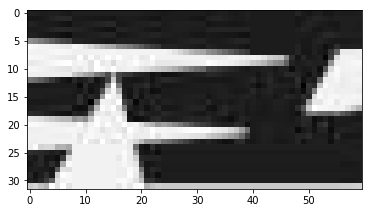

nbsklep.pl_2_x_33_y_12_label0.jpg


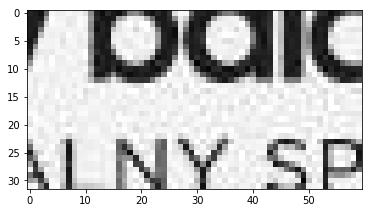

nbsklep.pl_2_x_33_y_15_label0.jpg


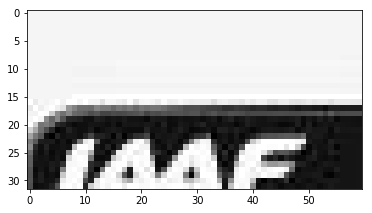

nbsklep.pl_2_x_33_y_22_label0.jpg


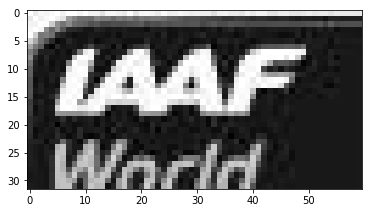

nbsklep.pl_2_x_33_y_23_label0.jpg


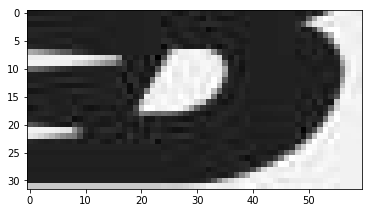

nbsklep.pl_2_x_34_y_12_label0.jpg


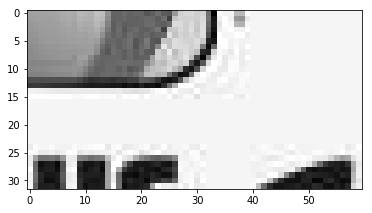

nbsklep.pl_2_x_34_y_28_label0.jpg


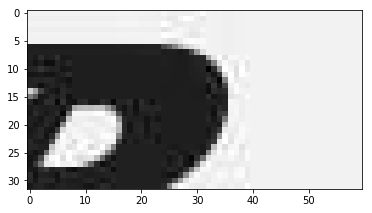

nbsklep.pl_2_x_35_y_10_label0.jpg


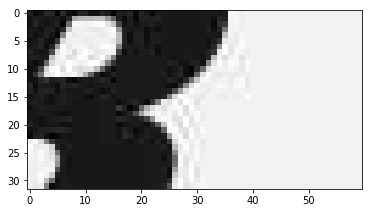

nbsklep.pl_2_x_35_y_11_label0.jpg


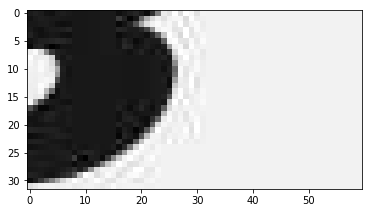

nbsklep.pl_2_x_35_y_12_label0.jpg


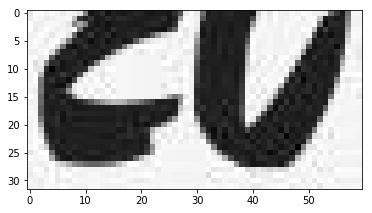

nbsklep.pl_2_x_35_y_30_label0.jpg


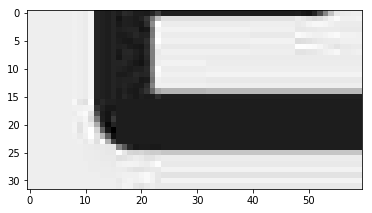

nbsklep.pl_2_x_6_y_26_label0.jpg


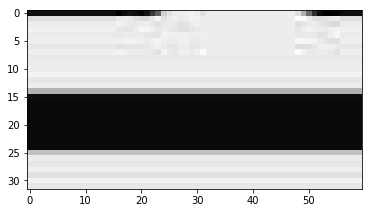

nbsklep.pl_2_x_7_y_26_label0.jpg


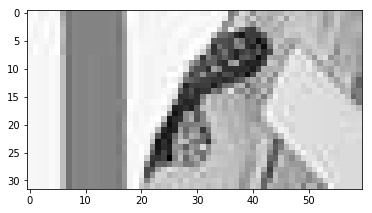

nbsklep.pl_3_x_17_y_17_label0.jpg


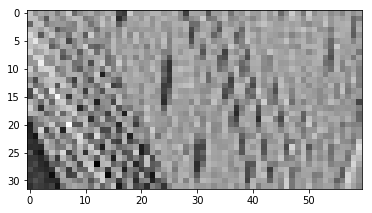

nbsklep.pl_3_x_18_y_25_label0.jpg


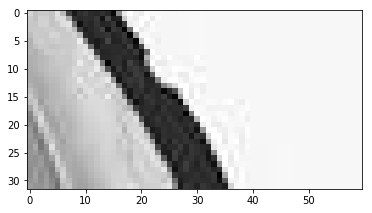

nbsklep.pl_3_x_21_y_8_label0.jpg


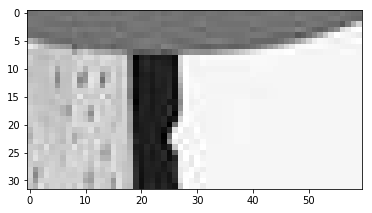

nbsklep.pl_3_x_22_y_27_label0.jpg


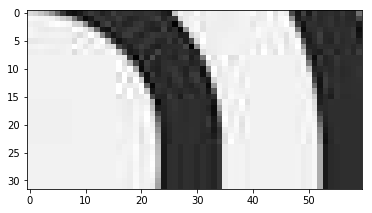

nbsklep.pl_3_x_23_y_16_label0.jpg


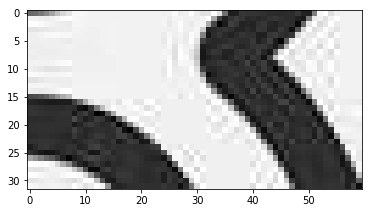

nbsklep.pl_3_x_23_y_20_label0.jpg


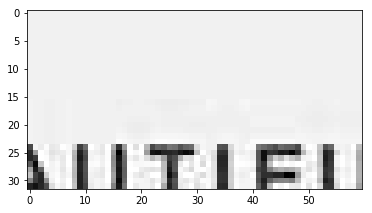

nbsklep.pl_3_x_25_y_33_label0.jpg


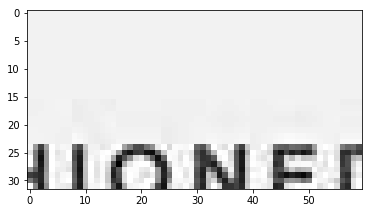

nbsklep.pl_3_x_30_y_33_label0.jpg


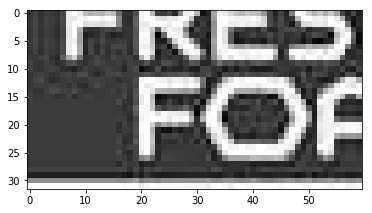

nbsklep.pl_3_x_6_y_5_label0.jpg


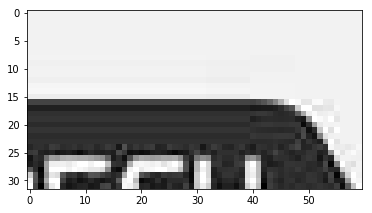

nbsklep.pl_3_x_7_y_3_label0.jpg


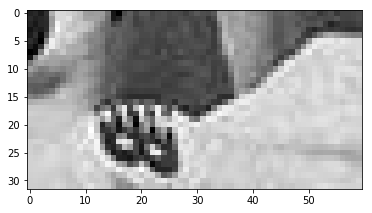

nbsklep.pl_4_x_10_y_16_label0.jpg


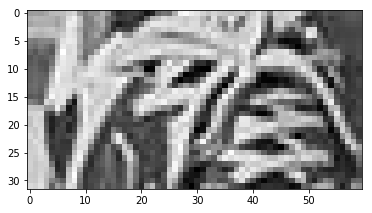

nbsklep.pl_4_x_13_y_34_label0.jpg


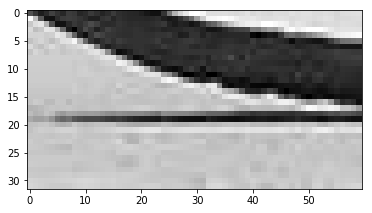

nbsklep.pl_4_x_22_y_38_label0.jpg


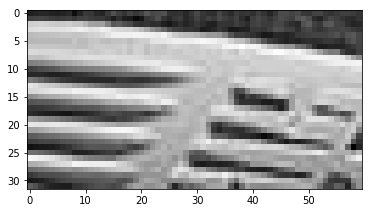

nbsklep.pl_4_x_23_y_33_label0.jpg


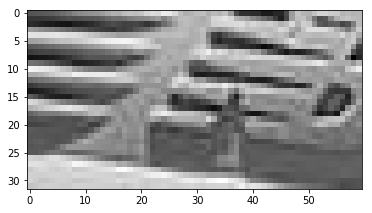

nbsklep.pl_4_x_23_y_34_label0.jpg


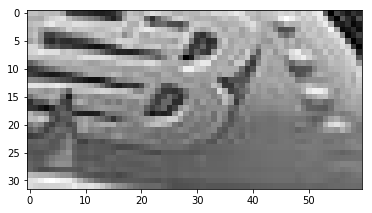

nbsklep.pl_4_x_24_y_34_label0.jpg


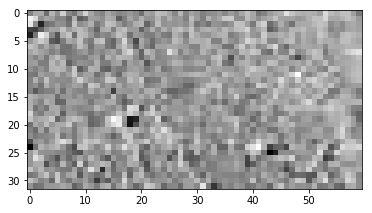

nbsklep.pl_6_x_5_y_28_label0.jpg


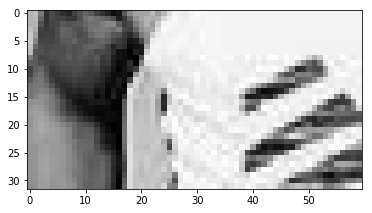

nbsklep.pl_6_x_6_y_8_label0.jpg


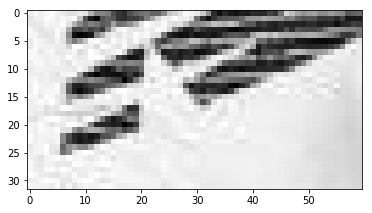

nbsklep.pl_6_x_7_y_10_label0.jpg


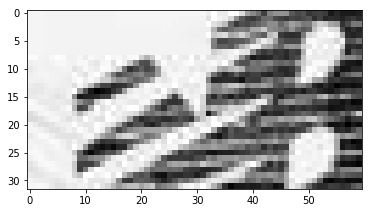

nbsklep.pl_6_x_7_y_8_label0.jpg


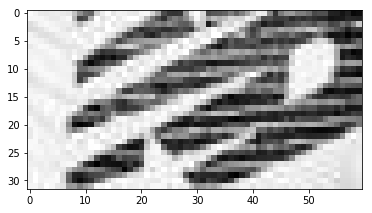

nbsklep.pl_6_x_7_y_9_label0.jpg


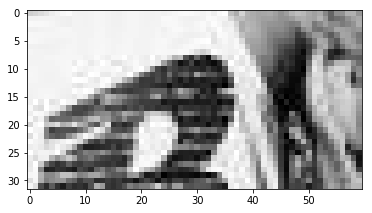

nbsklep.pl_6_x_8_y_7_label0.jpg


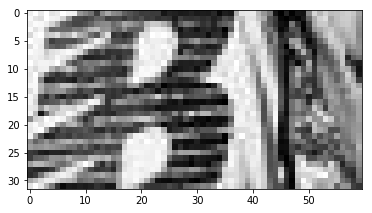

nbsklep.pl_6_x_8_y_8_label0.jpg


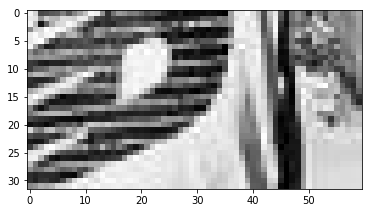

nbsklep.pl_6_x_8_y_9_label0.jpg


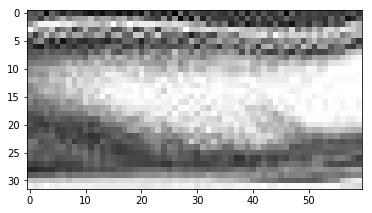

nbsklep.pl_7_x_11_y_20_label0.jpg


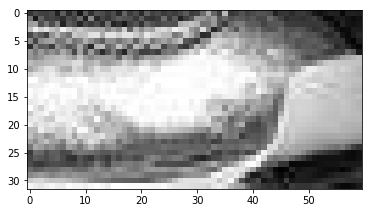

nbsklep.pl_7_x_12_y_20_label0.jpg


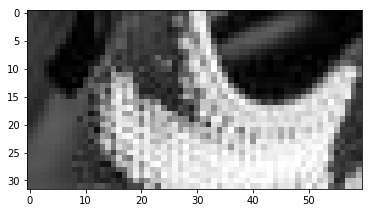

nbsklep.pl_9_x_5_y_18_label0.jpg


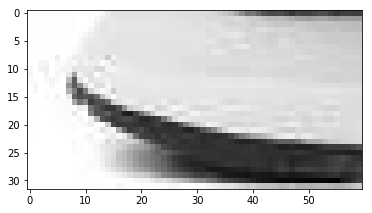

pigu.lt_5_x_0_y_6_label0.jpg


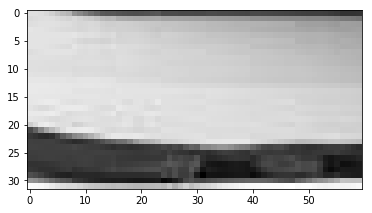

pigu.lt_5_x_1_y_6_label0.jpg


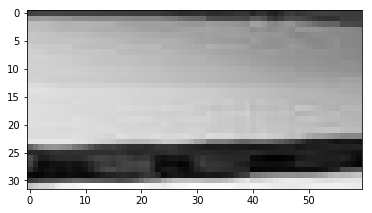

pigu.lt_5_x_2_y_6_label0.jpg


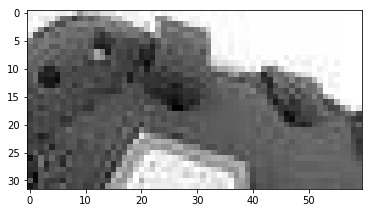

pigu.lt_5_x_4_y_1_label0.jpg


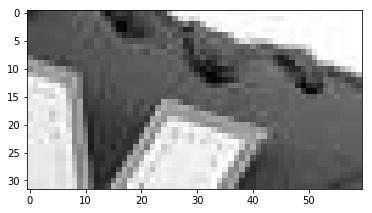

pigu.lt_5_x_5_y_2_label0.jpg


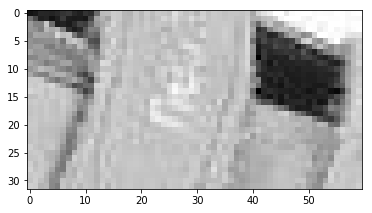

pigu.lt_6_x_4_y_1_label0.jpg


KeyboardInterrupt: 

In [35]:
positive_predicted = train_and_predict(data,3303)

create array of positive examples, then change our data

In [ ]:
positive_examples = [
    'nbsklep.pl_21_x_9_y_16_label0.jpg',
    'nbsklep.pl_21_x_9_y_17_label0.jpg',
    'nbsklep.pl_0_x_4_y_23_label0.jpg',
    'lt.wikipedia.org_0_x_0_y_0_label0.jpg',
    'lt.wikipedia.org_0_x_0_y_1_label0.jpg',
    'lt.wikipedia.org_0_x_1_y_0_label0.jpg',
    'lt.wikipedia.org_0_x_1_y_1_label0.jpg',
    'lt.wikipedia.org_0_x_2_y_0_label0.jpg',
    'nbsklep.pl_2_x_32_y_12_label0.jpg',
    'nbsklep.pl_2_x_33_y_12_label0.jpg',
    'nbsklep.pl_2_x_34_y_12_label0.jpg',
    'nbsklep.pl_2_x_35_y_10_label0.jpg',
    'nbsklep.pl_2_x_35_y_11_label0.jpg',
    'nbsklep.pl_2_x_35_y_12_label0.jpg',
    'nbsklep.pl_13_x_7_y_5_label0.jpg',
    'nbsklep.pl_13_x_7_y_6_label0.jpg',
    'nbsklep.pl_13_x_8_y_5_label0.jpg',
    'nbsklep.pl_13_x_8_y_6_label0.jpg',
    'nbsklep.pl_25_x_7_y_5_label0.jpg',
    'nbsklep.pl_25_x_7_y_6_label0.jpg',
    'nbsklep.pl_26_x_6_y_8_label0.jpg',
    'nbsklep.pl_26_x_7_y_8_label0.jpg',
    'nbsklep.pl_26_x_7_y_9_label0.jpg',
    'nbsklep.pl_26_x_7_y_10_label0.jpg',
    'nbsklep.pl_26_x_8_y_7_label0.jpg',
    'nbsklep.pl_26_x_8_y_8_label0.jpg',
    'nbsklep.pl_26_x_8_y_9_label0.jpg',
    'nbsklep.pl_6_x_6_y_8_label0.jpg',
    'nbsklep.pl_6_x_7_y_8_label0.jpg',
    'nbsklep.pl_6_x_7_y_9_label0.jpg',
    'nbsklep.pl_6_x_8_y_7_label0.jpg',
    'nbsklep.pl_6_x_8_y_9_label0.jpg',
    'nbsklep.pl_4_x_24_y_34_label0.jpg',
    'nbsklep.pl_4_x_23_y_33_label0.jpg',
    'nbsklep.pl_4_x_23_y_34_label0.jpg',
    'nbsklep.pl_4_x_10_y_16_label0.jpg']
data = add_data(data,positive_examples)
print(len(data))

In [36]:
neuro = classifiers[-1]

In [37]:
def opener(image):
    line=np.array(image.resize(format_small_size).filter(ImageFilter.CONTOUR)).reshape(1,format_small_area)[0]
    min_line = min(line)
    delta = max(line)-min_line
    if delta>0:
        return [[(t-min_line)/delta for t in line]] # rescaled line
    else:
        return [np.zeros(len(line))] # simple zeros line

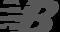

In [38]:
img = Image.open('../examples/1/lt.wikipedia.org_0_x_1_y_0_label0.jpg')
img

In [39]:
neuro.predict(opener(img))

array([1.])

In [40]:
file_list = !ls ../screen/
img = Image.open('../screen/'+file_list[2]).convert('L')
img_size = img.size

format_sizes = [list(np.array(format_small_size)*i) for i in range(1,3)] # number of zooms =  (number of different sample sizes)
for i in range(0,img.size[0]*2//format_sizes[0][0]): # move for half of size for a step
    for j in range(0,img.size[1]*2//format_sizes[0][1]):
        image = crop_single(img,i,j,format_sizes[0]).resize(format_sizes[0])
        if (abs(min(op[0])-max(op[0]))>5):
            print(neuro.predict(opener(PIL.ImageOps.invert(image)))[0]>0 or neuro.predict(opener(image))[0]>0,i,j)
            imshow(np.array(image), cmap="gray")
            plt.show()